In [69]:
import pandas as pd
import os

df = pd.DataFrame()
"""
for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)])
    print(f"Added {json_file} to dataframe.")
"""
df = pd.read_json('dataset/jsonl/en-US.jsonl', lines=True)

In [90]:
%run -i "preprocess_lang.ipynb"
%run -i "preprocess_nolang.ipynb"
%run -i "evaluation.ipynb"

In [71]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
0,0,en-US,test,alarm,alarm_set,wake me up at five am this week,wake me up at [time : five am] [date : this week],1
1,1,en-US,train,alarm,alarm_set,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1
2,2,en-US,train,alarm,alarm_set,set an alarm for two hours from now,set an alarm for [time : two hours from now],1
3,3,en-US,test,audio,audio_volume_mute,quiet,quiet,1
4,4,en-US,train,audio,audio_volume_mute,olly quiet,olly quiet,1


In [72]:
from toolz.functoolz import pipe

df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming
]


df = pipe(
    df,
    *params
)


df['utt'] = df['utt'].apply(lambda x: " ".join(x))
df, encoder = encode_labels(df)

print(f"Finished preprocessing dataset.\n\n")


Finished preprocessing dataset.




In [73]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,utt_text
0,0,en,test,alarm,2,wake me up at five am this week,wake me up at [time : five am] [date : this week],1,"(w, a, k, e, , m, e, , u, p, , a, t, , f, ..."
1,1,en,train,alarm,2,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"(w, a, k, e, , m, e, , u, p, , a, t, , n, ..."
2,2,en,train,alarm,2,set an alarm for two hour from now,set an alarm for [time : two hours from now],1,"(s, e, t, , a, n, , a, l, a, r, m, , f, o, ..."
3,3,en,test,audio,4,quiet,quiet,1,"(q, u, i, e, t)"
4,4,en,train,audio,4,olli quiet,olly quiet,1,"(o, l, l, y, , q, u, i, e, t)"


In [74]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(df['utt'].to_list())


In [75]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [76]:
count_vect_df = pd.DataFrame(vectorized.todense(), columns=input_cols)
df = pd.concat([df, count_vect_df], axis=1)

In [77]:
training_df = df[df['partition'] != 'test']
testing_df = df[df['partition'] == 'test']

In [78]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [79]:
training_inputs = vectorizer.transform(training_df['utt'].values)
testing_inputs = vectorizer.transform(testing_df['utt'].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [80]:
english_indices = testing_df.index[(testing_df['locale'] == 'en')].values
chinese_indices = testing_df.index[(testing_df['locale'] == 'zh')].values
japanese_indices = testing_df.index[(testing_df['locale'] == 'ja')].values
arabic_indices = testing_df.index[(testing_df['locale'] == 'ar')].values

indices = {
    'en': english_indices,
    'zh': chinese_indices,
    'ja': japanese_indices,
    'ar': arabic_indices
}

In [91]:
from sklearn.naive_bayes import MultinomialNB

nb = train_and_use_model(
    MultinomialNB(),
    {
        "model__alpha": [0.1, 0.5, 1.0, 1.5, 2.0],
    },
    n_iter=1,
    indices=indices,
    encoder=encoder,
)

# MultinomialNB

Best params:
{
    'model__alpha': 0.1
}

In [9]:
#import xgboost as xgb
import xgboost as xgb

xgboost = train_and_use_model(
    xgb.XGBClassifier(),
    {
        "model__n_estimators": [100, 200, 300, 400, 500],
        "model__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "model__booster": ["gbtree", "gblinear", "dart"],
        "model__gamma": [0, 0.25, 0.5, 1.0],
        "model__min_child_weight": [1, 3, 5, 7],
        "model__max_delta_step": [0, 0.2, 0.6, 1.0],
        "model__subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    },
    n_iter=3
)

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\

[04:44:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.

Best params for XGBClassifier: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__max_delta_step': 1.0, 'model__learning_rate': 0.05, 'model__gamma': 0.5, 'model__booster': 'gblinear'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.7887292811188353
Classification report
              precision    recall  f1-score   support

           0     0.9032    0.8235    0.8615        34
           1     0.9474    0.8571    0.9000        21
           2     0.7907    0.8293    0.8095        41
           3     0.8182    0.8182    0.8182        11
           4     0.8333    0.9375    0.8824        32
           5     1.0000    0.3333    0.50

# XGBoost

Best Params:
{
    'model__subsample': 0.7,
    'model__n_estimators': 200, 
    'model__min_child_weight': 3, 
    'model__max_depth': 3, 
    'model__max_delta_step': 1.0, 
    'model__learning_rate': 0.05, 
    'model__gamma': 0.5, 
    'model__booster': 'gblinear'
}

In [10]:
from sklearn.linear_model import LogisticRegression

knn = train_and_use_model(
    LogisticRegression(),
    {
        "model__penalty": ['l2', None],
        "model__solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        "model__C": [0.1, 0.5, 1.0, 1.5, 2.0],
        "model__max_iter": [100, 200, 300, 400, 500],
        "model__class_weight": ['balanced', None]
    },
    n_iter=1
)

# Logistic Regression

Best Params:
{
    'model__penalty': 0.7,
    'model__solver': 200, 
    'model__C': 3, 
    'model__max_iter': 3, 
    'model__class_weight': 1.0
}

In [31]:
import os
import pandas as pd

df = pd.DataFrame()

for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)], ignore_index=True)
    print(f"Added {json_file} to dataframe.")

df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

Added af-ZA.jsonl to dataframe.
Added am-ET.jsonl to dataframe.
Added ar-SA.jsonl to dataframe.
Added az-AZ.jsonl to dataframe.
Added bn-BD.jsonl to dataframe.
Added cy-GB.jsonl to dataframe.
Added da-DK.jsonl to dataframe.
Added de-DE.jsonl to dataframe.
Added el-GR.jsonl to dataframe.
Added en-US.jsonl to dataframe.
Added es-ES.jsonl to dataframe.
Added fa-IR.jsonl to dataframe.
Added fi-FI.jsonl to dataframe.
Added fr-FR.jsonl to dataframe.
Added he-IL.jsonl to dataframe.
Added hi-IN.jsonl to dataframe.
Added hu-HU.jsonl to dataframe.
Added hy-AM.jsonl to dataframe.
Added id-ID.jsonl to dataframe.
Added is-IS.jsonl to dataframe.
Added it-IT.jsonl to dataframe.
Added ja-JP.jsonl to dataframe.
Added jv-ID.jsonl to dataframe.
Added ka-GE.jsonl to dataframe.
Added km-KH.jsonl to dataframe.
Added kn-IN.jsonl to dataframe.
Added ko-KR.jsonl to dataframe.
Added lv-LV.jsonl to dataframe.
Added ml-IN.jsonl to dataframe.
Added mn-MN.jsonl to dataframe.
Added ms-MY.jsonl to dataframe.
Added my

In [32]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments
0,0,af,test,alarm,alarm_set,maak my wakker om vyf v. m. die week,maak my wakker om [time : vyf v. m.] [date : d...,37,"[{'slot': 'time', 'method': 'localization'}, {...","[{'worker_id': '20', 'intent_score': 1, 'slots..."
1,1,af,train,alarm,alarm_set,maak my wakker nege-uur v. m. op vrydag,maak my wakker [time : nege-uur v. m.] op [dat...,20,"[{'slot': 'time', 'method': 'translation'}, {'...","[{'worker_id': '40', 'intent_score': 1, 'slots..."
2,2,af,train,alarm,alarm_set,stel 'n alarm vir twee ure van nou af,stel 'n alarm vir [time : twee ure van nou af],20,"[{'slot': 'time', 'method': 'translation'}]","[{'worker_id': '64', 'intent_score': 1, 'slots..."
3,3,af,test,audio,audio_volume_mute,stil,stil,40,[],"[{'worker_id': '45', 'intent_score': 1, 'slots..."
4,4,af,train,audio,audio_volume_mute,janneman stilte,janneman stilte,40,[],"[{'worker_id': '45', 'intent_score': 1, 'slots..."


In [38]:
from toolz.functoolz import pipe

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming,
]

df = pipe(
    df,
    *params
)

df, encoder = encode_labels(df)

df['utt'] = df['utt'].apply(lambda x: " ".join(x))

print(f"Finished preprocessing dataset.\n\n")



Finished preprocessing dataset.




In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(df[df['partition'] != 'test']['utt'].values)

TfidfVectorizer()

In [40]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [49]:
training_df = df[df['partition'] != 'test']
testing_df = df[df['partition'] == 'test']

In [50]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [51]:
training_inputs = vectorizer.transform(training_df['utt'].values)
testing_inputs = vectorizer.transform(testing_df['utt'].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [53]:
english_indices = testing_df.index[(testing_df['locale'] == 'en')].values
chinese_indices = testing_df.index[(testing_df['locale'] == 'zh')].values
japanese_indices = testing_df.index[(testing_df['locale'] == 'ja')].values
arabic_indices = testing_df.index[(testing_df['locale'] == 'ar')].values

indices = {
    'en': english_indices,
    'zh': chinese_indices,
    'ja': japanese_indices,
    'ar': arabic_indices
}

In [54]:
# get values of the training classes according to the japanese indices
ja_values = testing_classes[japanese_indices]
ja_values

array([ 2,  4, 23, ..., 15, 15, 15])

In [55]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.1)

nb.fit(training_inputs, training_classes)


MultinomialNB(alpha=0.1)

Evaluation metrics for MultinomialNB
MultinomialNB's default score metric: 0.7516647546712028
Classification report
              precision    recall  f1-score   support

           0     0.9286    0.7122    0.8061      1734
           1     0.9577    0.5500    0.6987      1071
           2     0.7504    0.7303    0.7402      2091
           3     0.9380    0.5936    0.7271       561
           4     0.8971    0.6624    0.7621      1632
           5     1.0000    0.0327    0.0633       306
           6     0.4856    0.6094    0.5405       663
           7     0.5612    0.7081    0.6261      6426
           8     0.8136    0.8306    0.8220      3417
           9     0.6147    0.9096    0.7336     10659
          11     0.9158    0.7557    0.8281      3672
          12     0.9683    0.2392    0.3836       765
          13     0.7979    0.8324    0.8148      4488
          14     0.6828    0.2075    0.3183       612
          15     0.8041    0.9058    0.8519      6069
          16     0.

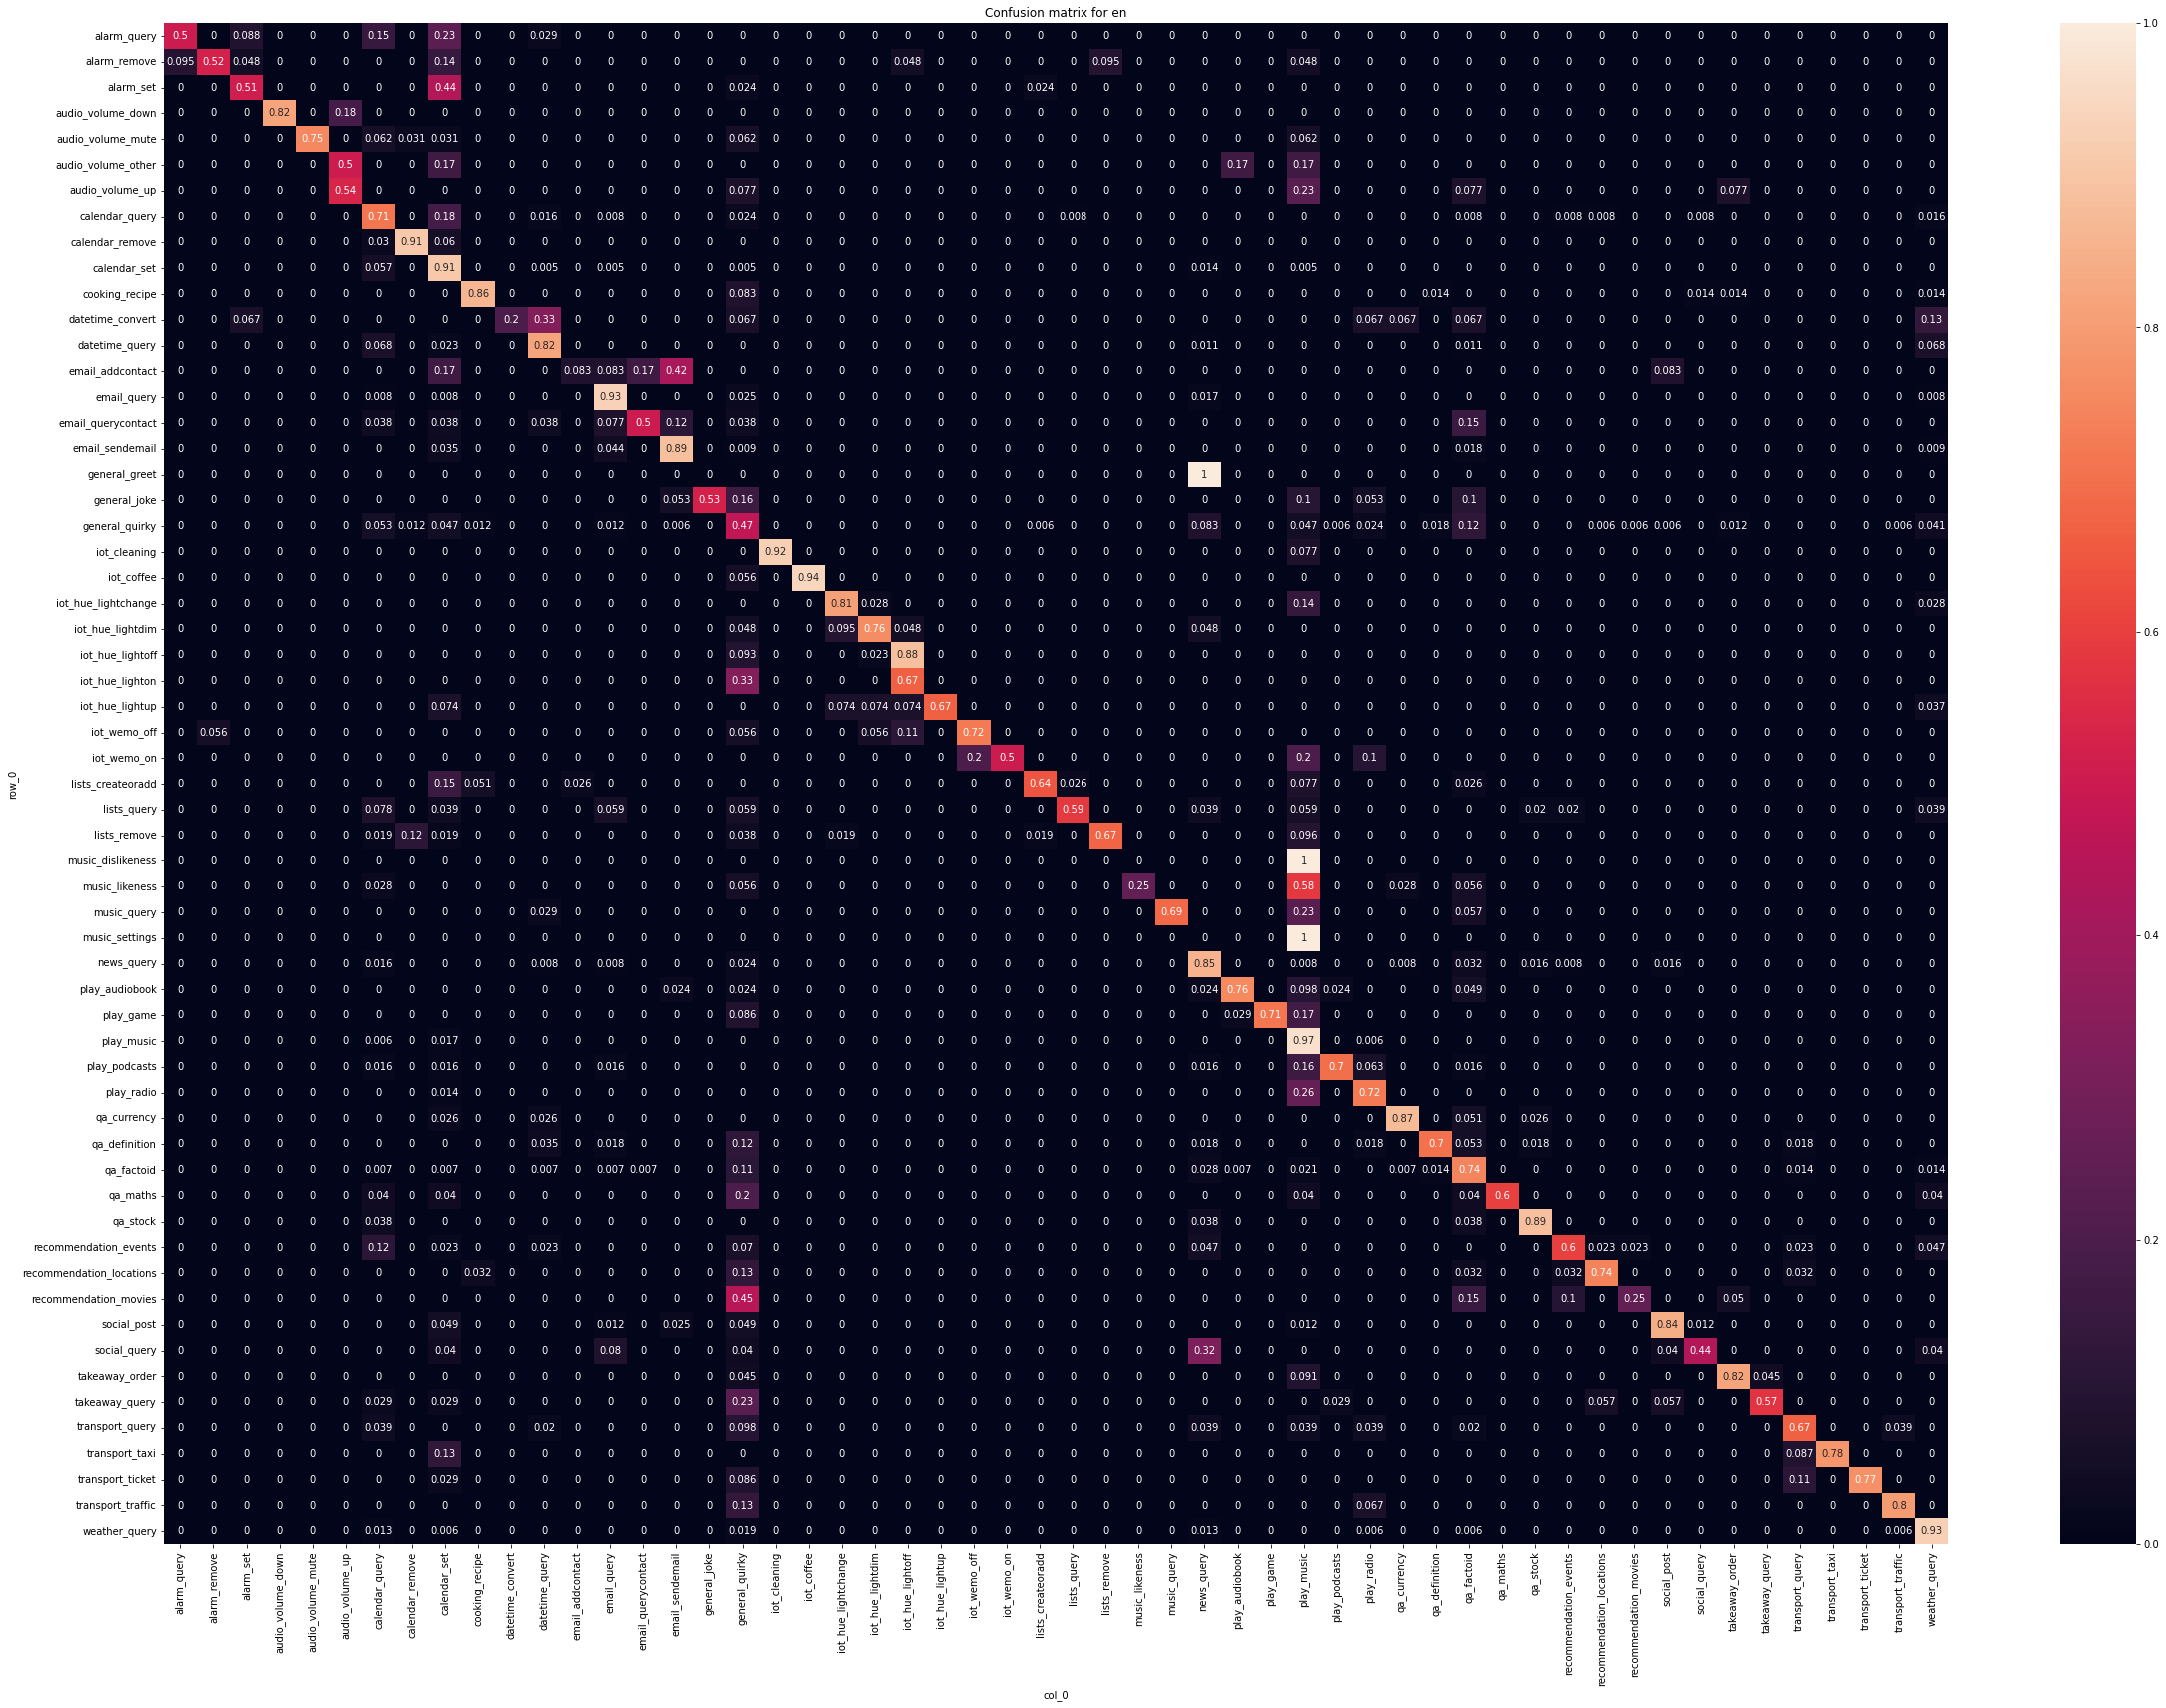

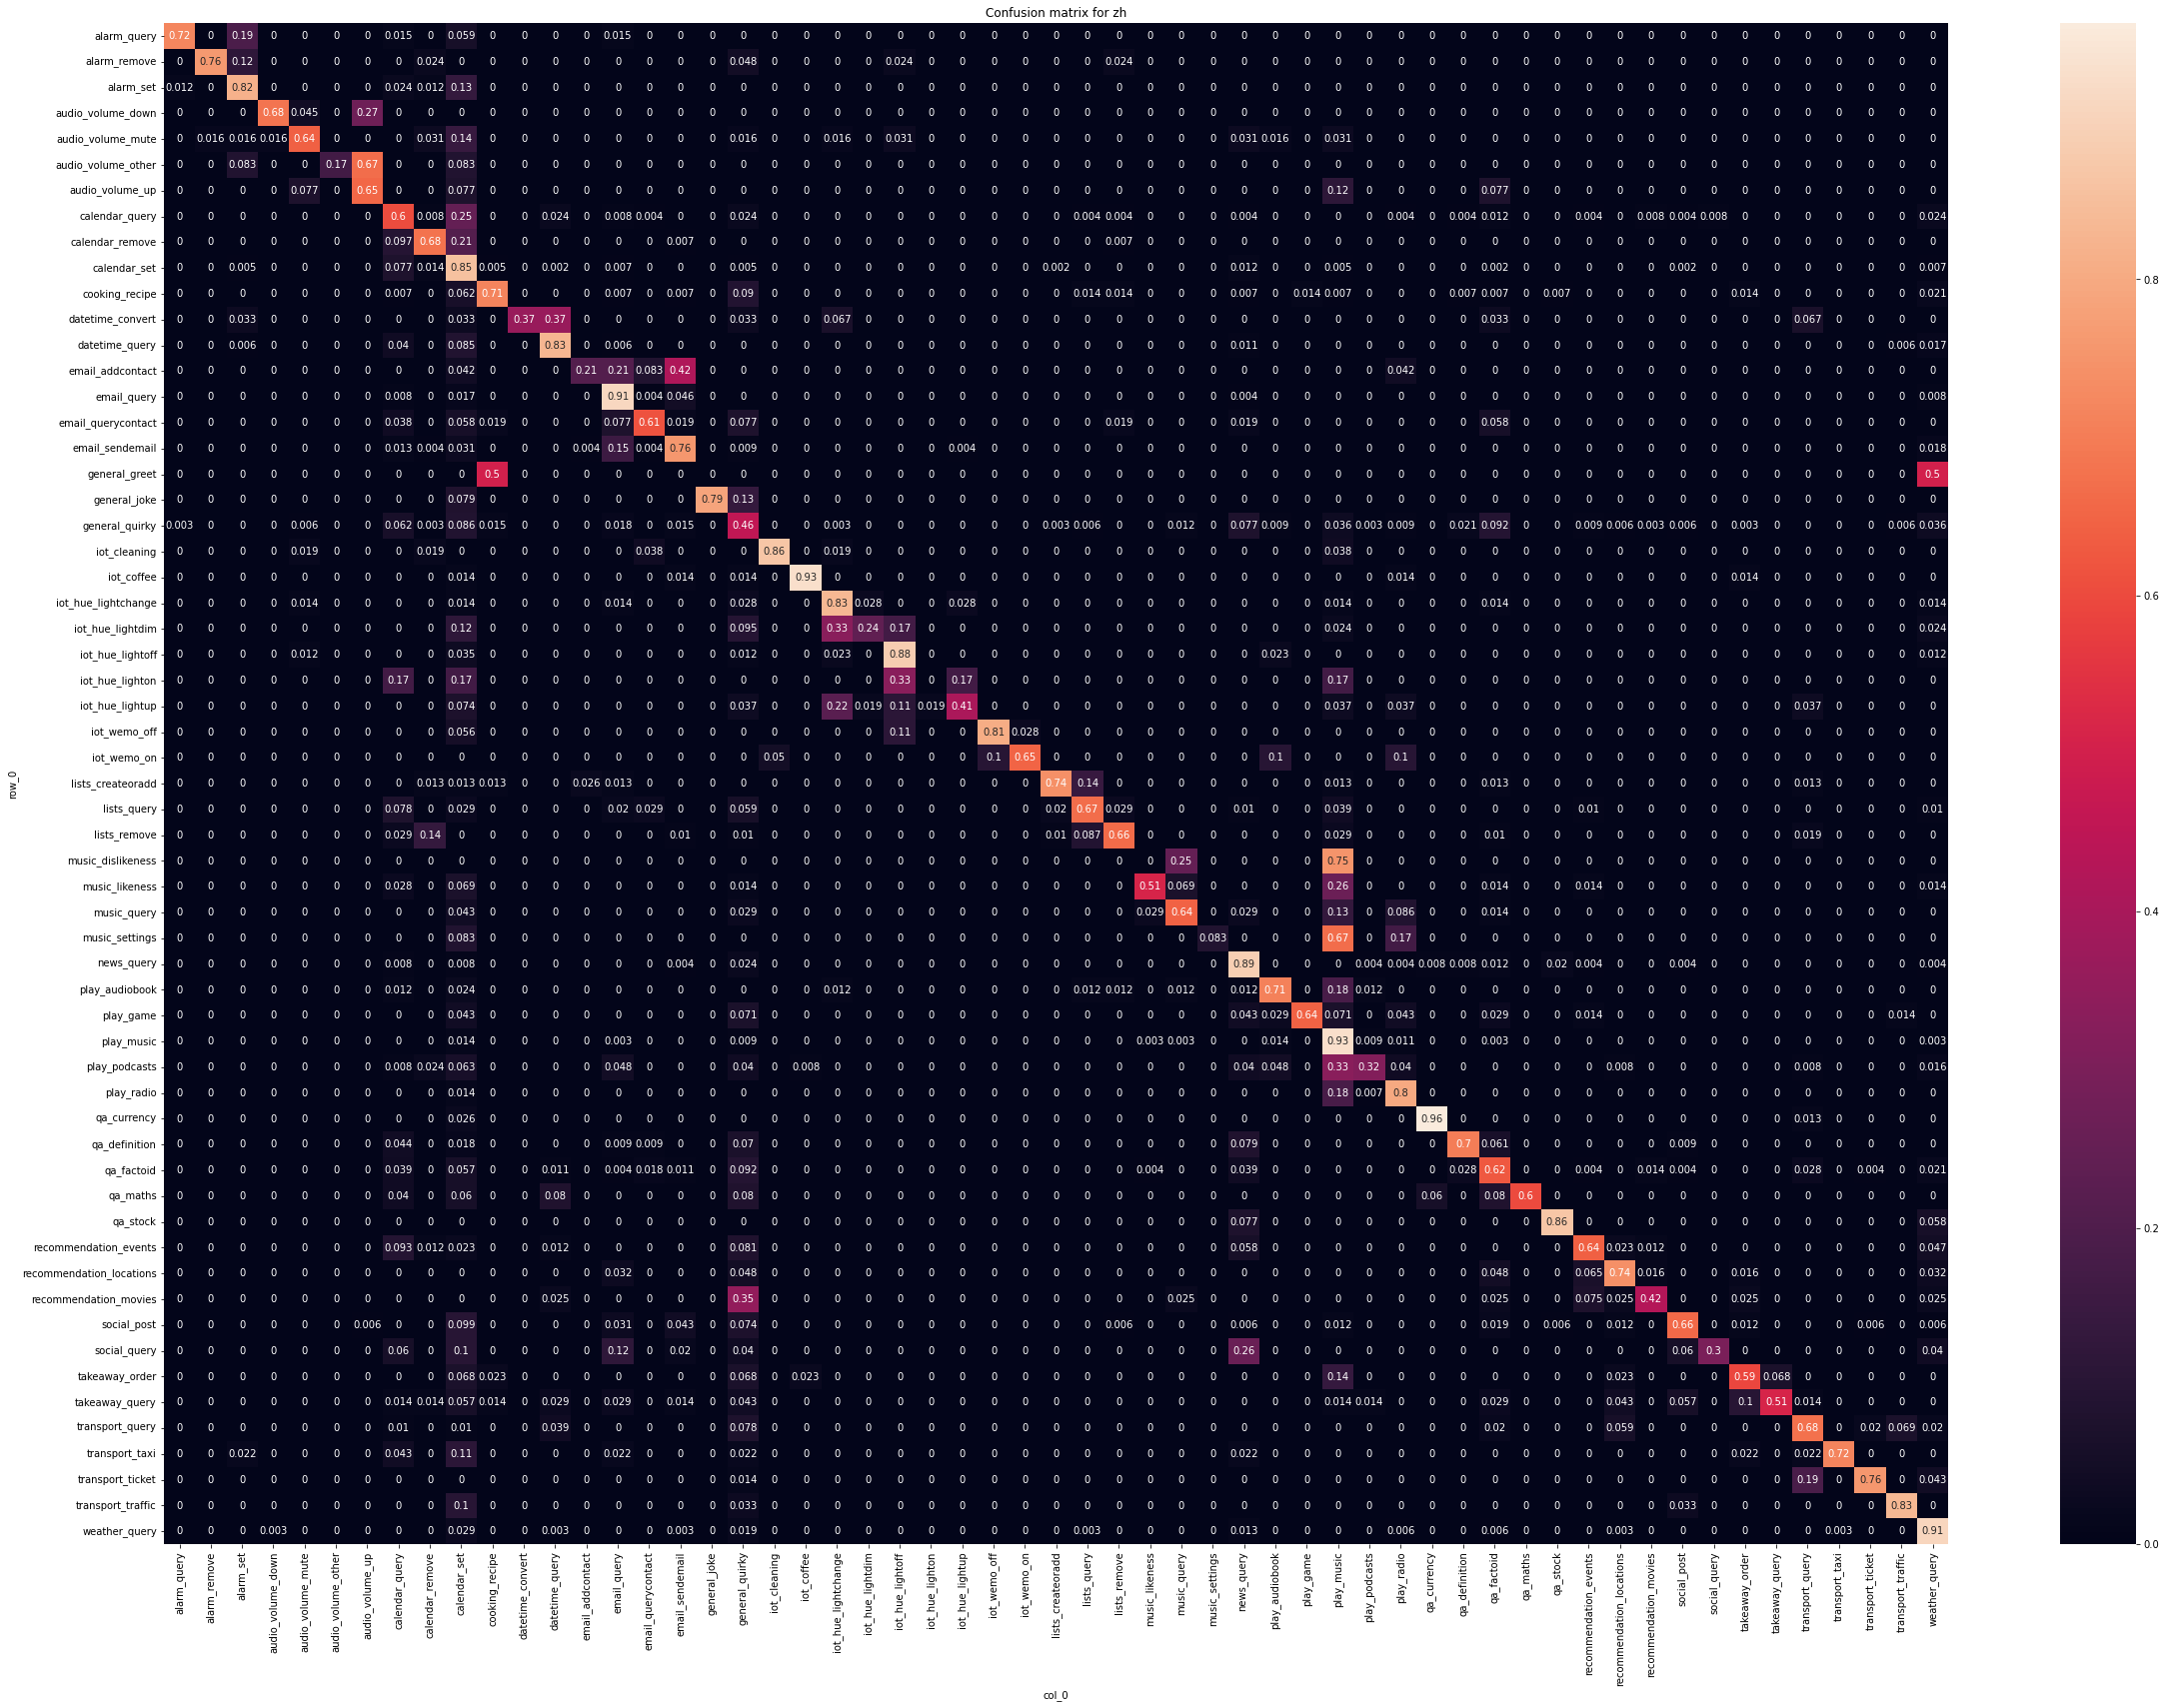

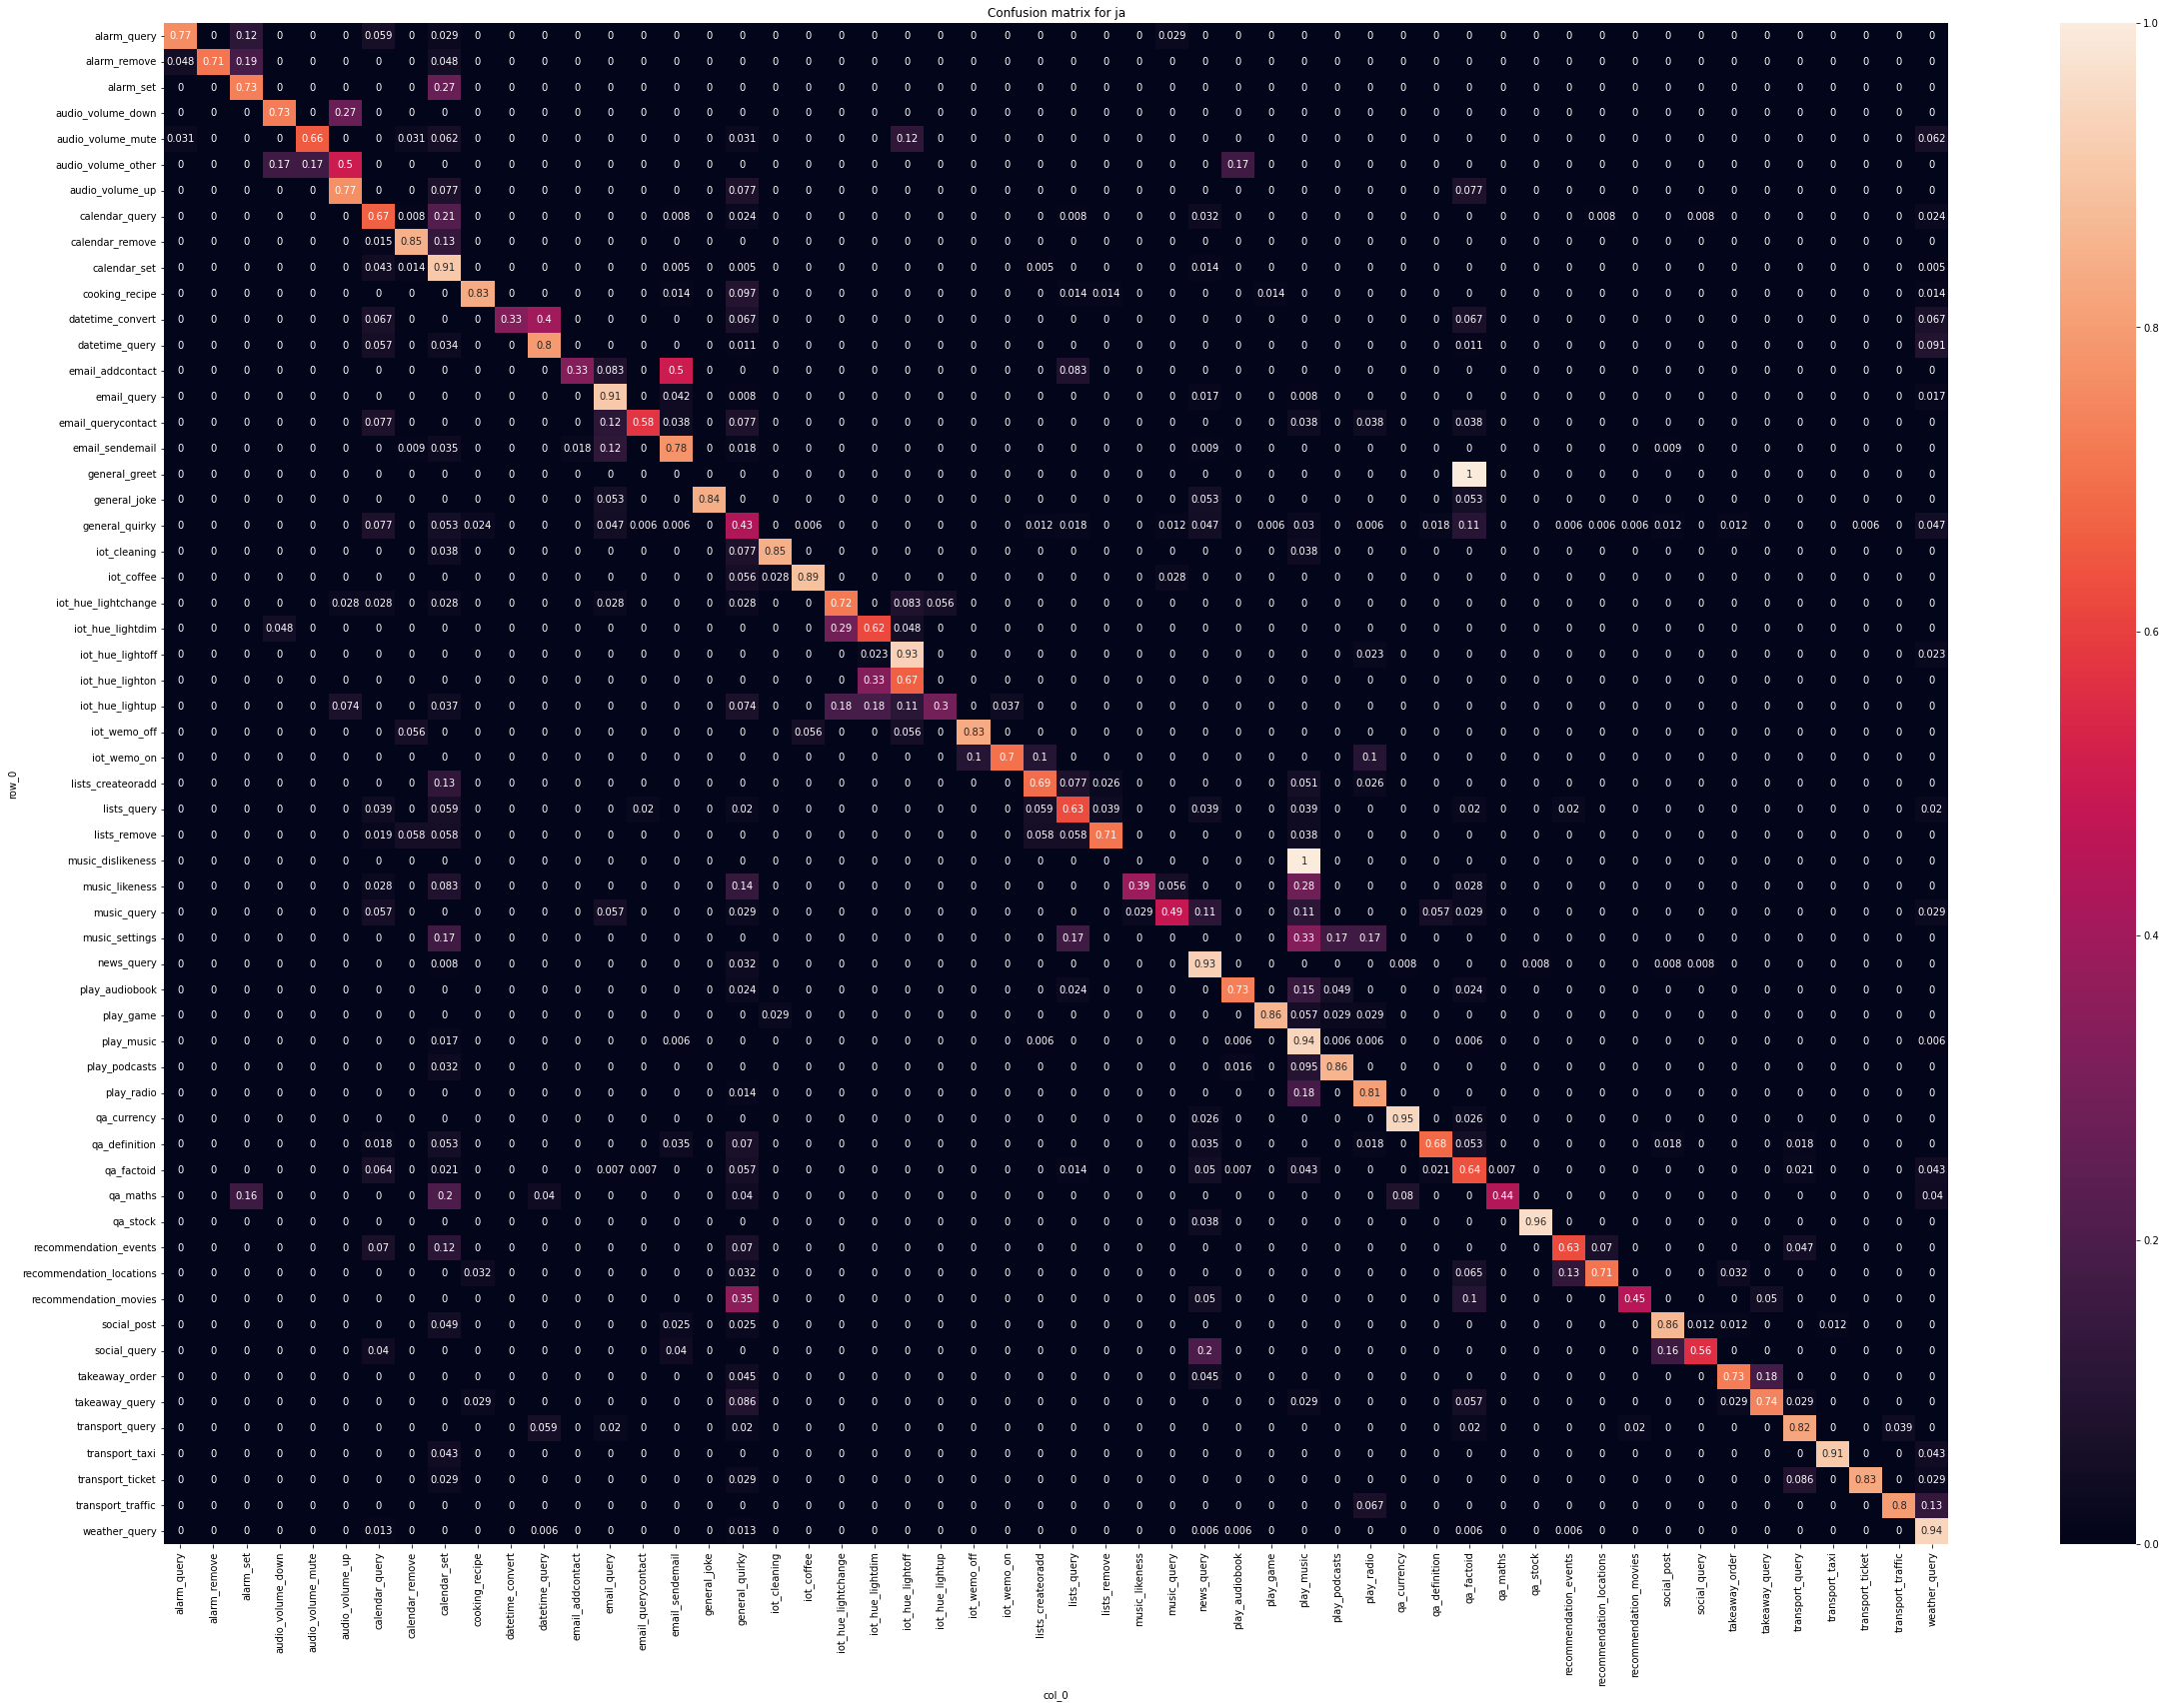

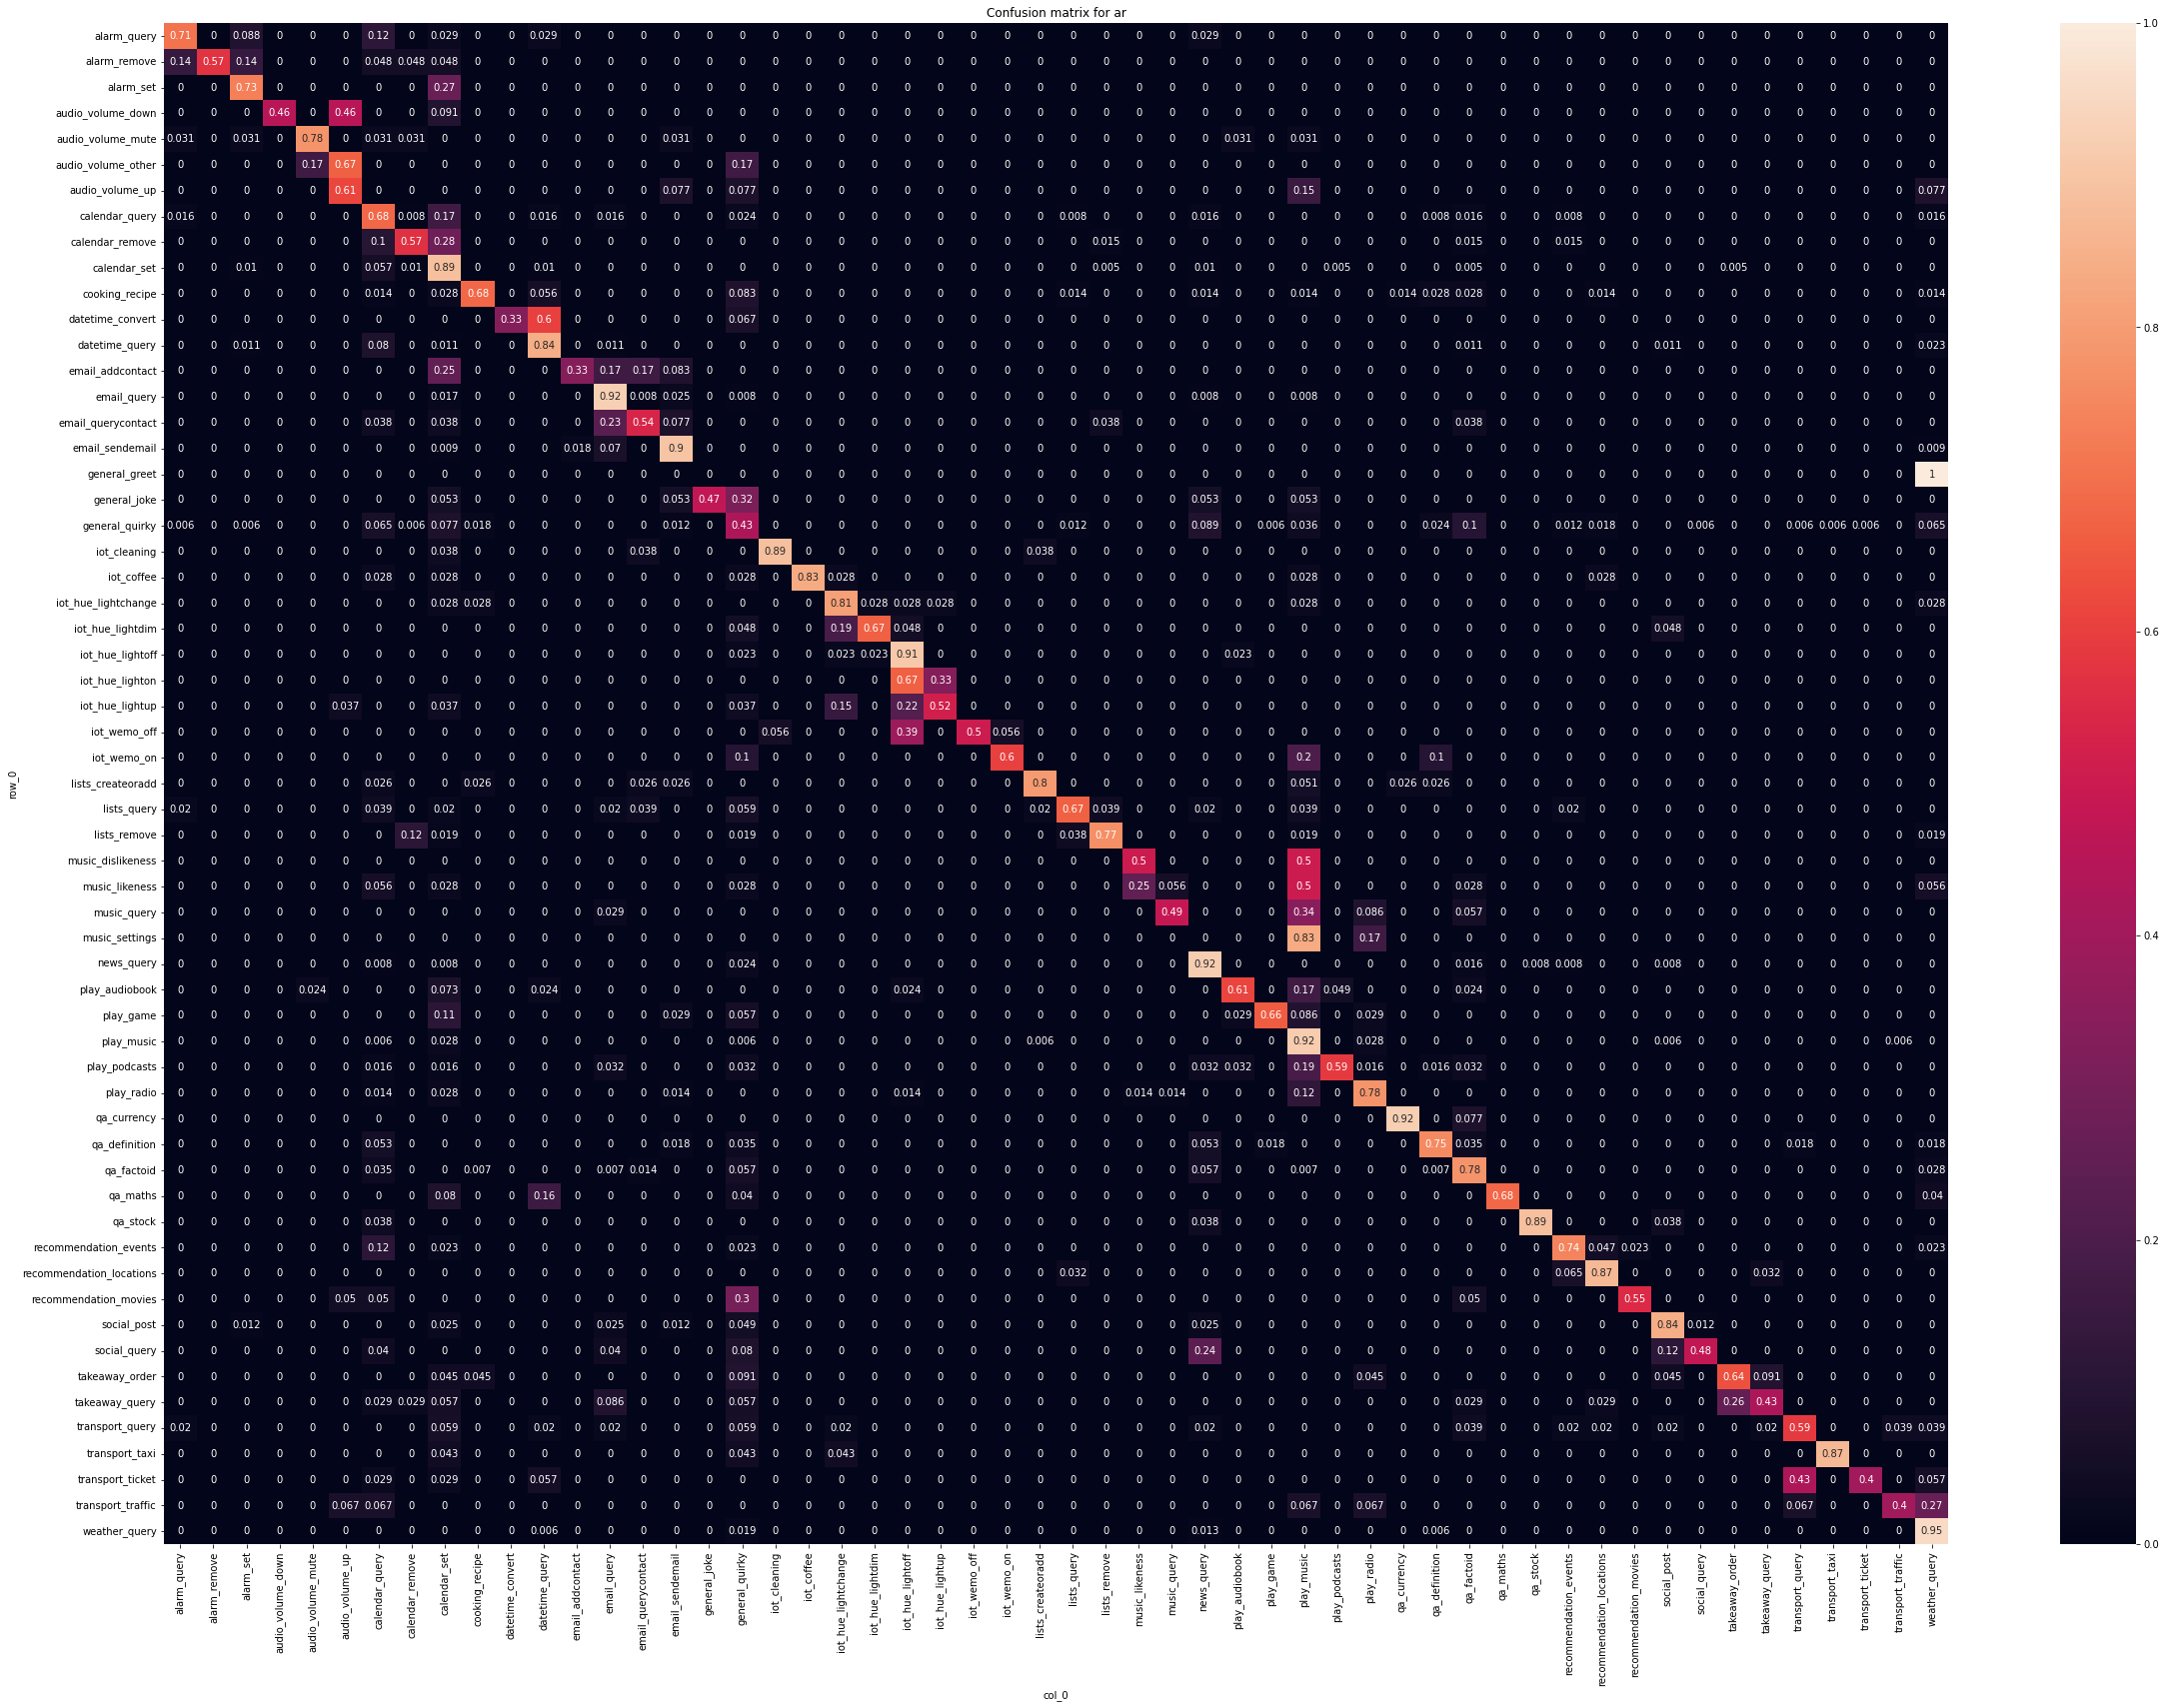

In [62]:
evaluate_model(nb, testing_inputs, testing_classes, encoder, indices)


In [12]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(subsample=0.7, n_estimators=200, min_child_weight=3, max_depth=3, max_delta_step=1, learning_rate=0.05, gamma=0.5, booster='gblinear')

xgboost.fit(training_inputs, training_classes)

[17:17:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.



XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=3, max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [13]:
evaluate_model(xgboost, testing_inputs, testing_classes, input_cols)

Evaluation metrics for XGBClassifier
XGBClassifier's default score metric: 0.7518493611297915
Classification report
              precision    recall  f1-score   support

           0     0.8398    0.7860    0.8120      1734
           1     0.8256    0.7600    0.7914      1071
           2     0.7099    0.8250    0.7631      2091
           3     0.7661    0.8467    0.8044       561
           4     0.7741    0.7917    0.7828      1632
           5     0.7372    0.3758    0.4978       306
           6     0.5755    0.7240    0.6413       663
           7     0.5714    0.6760    0.6193      6426
           8     0.7762    0.8589    0.8155      3417
           9     0.7744    0.8017    0.7878     10659
          10     0.0000    1.0000    0.0000         0
          11     0.8863    0.7320    0.8018      3672
          12     0.7241    0.5490    0.6245       765
          13     0.7583    0.8592    0.8056      4488
          14     0.5526    0.5408    0.5467       612
          15     0.